<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2007%20-%20CNN%20Implementation/Lecture_07_SOTA_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

# Importar os pré-processamentos
from tensorflow.keras.applications import (
    VGG16, ResNet50, MobileNetV2, DenseNet121, EfficientNetB0
)
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficient

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


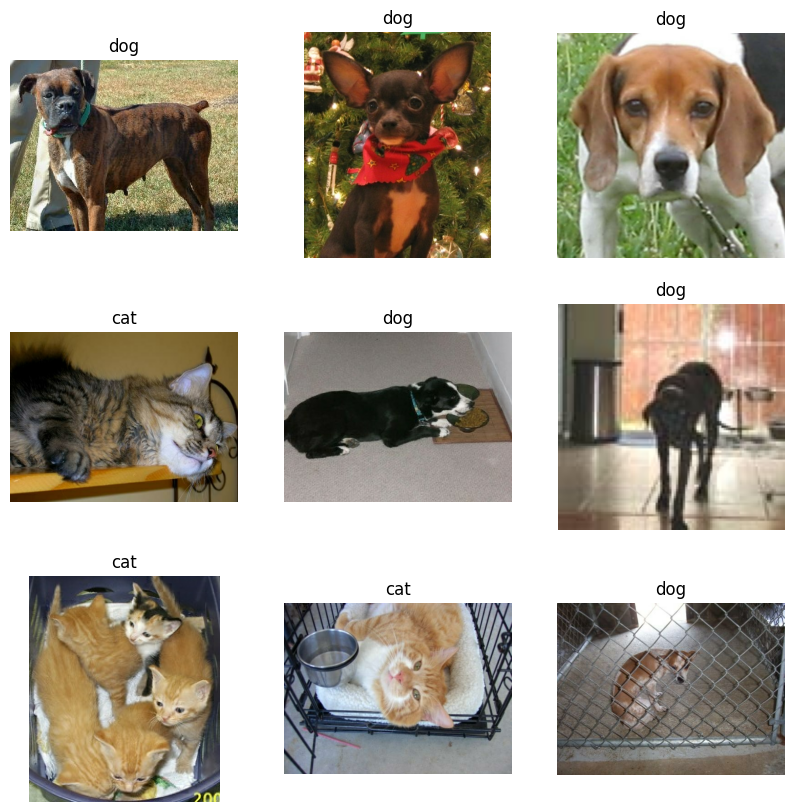

In [ ]:
(train_data, validation_data, test_data), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:30%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

label_names = info.features['label'].names

# Exibir amostras
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_data.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(label_names[label])
    plt.axis('off')
plt.show()

In [ ]:
def get_base_model(name, img_size):
    if name.lower() == 'vgg':
        base = VGG16(input_shape=img_size + (3,), include_top=False, weights='imagenet')
        preprocess_fn = preprocess_vgg
    elif name.lower() == 'resnet':
        base = ResNet50(input_shape=img_size + (3,), include_top=False, weights='imagenet')
        preprocess_fn = preprocess_resnet
    elif name.lower() == 'mobile':
        base = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
        preprocess_fn = preprocess_mobilenet
    elif name.lower() == 'dense':
        base = DenseNet121(input_shape=img_size + (3,), include_top=False, weights='imagenet')
        preprocess_fn = preprocess_densenet
    elif name.lower() == 'efficient':
        base = EfficientNetB0(input_shape=img_size + (3,), include_top=False, weights='imagenet')
        preprocess_fn = preprocess_efficient
    else:
        raise ValueError("Modelo inválido. Escolha entre: vgg, resnet, mobile, dense, efficient")

    base.trainable = False
    return base, preprocess_fn


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
MODEL_NAME = 'mobile'  # Escolha aqui: 'vgg', 'resnet', 'mobile', 'dense', 'efficient'
EPOCHS = 30


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
])


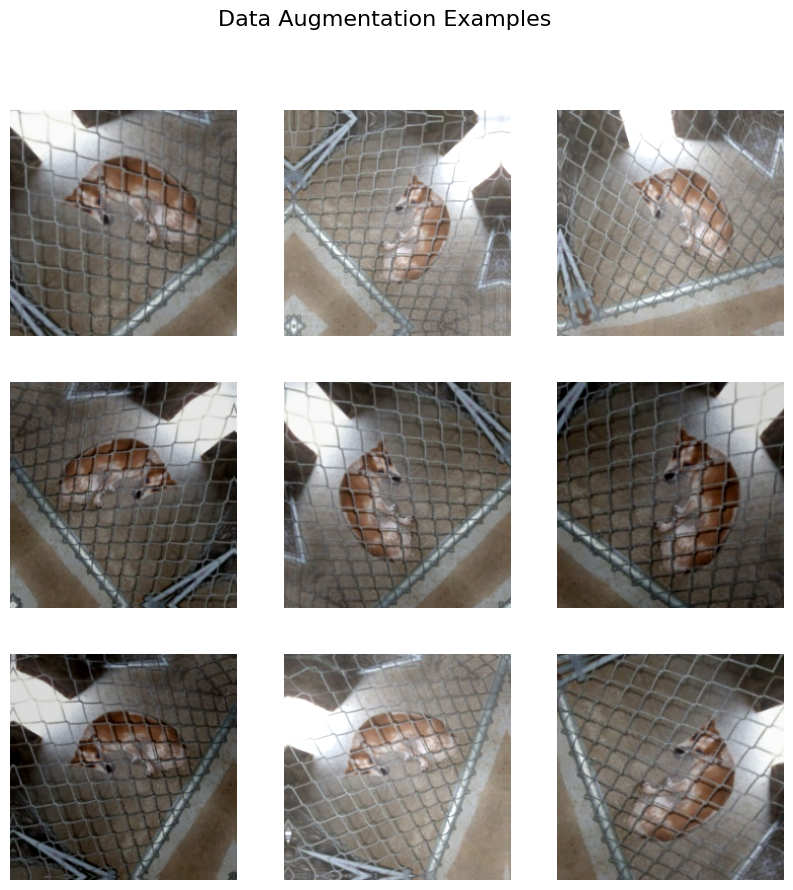

In [ ]:
# Supondo que 'image' seja [H, W, 3] do dataset original
image = tf.image.resize(image, IMG_SIZE)  # garante tamanho correto

plt.figure(figsize=(10, 10))
for i in range(9):
    # Adiciona dimensão de batch
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    ax = plt.subplot(3, 3, i + 1)
    # Remove dimensão de batch e converte para uint8
    plt.imshow(tf.cast(augmented_image[0], tf.uint8))
    plt.axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=16)
plt.show()

In [ ]:
import os

SAVE_DIR = "./models_cats_vs_dogs"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
def preprocess_image(x, y, preprocess_fn):
    x = tf.image.resize(x, IMG_SIZE)
    x = preprocess_fn(x)
    return x, y

def prepare_dataset(dataset, preprocess_fn):
    dataset = dataset.map(lambda x, y: preprocess_image(x, y, preprocess_fn))
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset



In [ ]:
histories = {}

for name in ['mobile','dense','efficient','resnet']:
    base_model, preprocess_fn = get_base_model(name,IMG_SIZE)


    train_dataset = prepare_dataset(train_data, preprocess_fn)
    val_dataset = prepare_dataset(validation_data, preprocess_fn)

    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.2),
    ])

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    outputs = layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    # Callbacks
    checkpoint_path = os.path.join(SAVE_DIR, f"{name}_best_weights.keras")
    callbacks = [
        ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1),

        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    # Treinamento inicial + fine-tuning em 50 épocas
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=EPOCHS,
                        callbacks=callbacks)


    histories[name] = history

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_56 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_19 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,074 (9.99 MB)

 Trainable params: 361,090 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/3
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5024 - loss: 0.7364
Epoch 1: val_loss improved from inf to 0.49075, saving model to ./models_cats_vs_dogs/mobile_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.5026 - loss: 0.7362 - val_accuracy: 0.8474 - val_loss: 0.4907
Epoch 2/3
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5484 - loss: 0.6866
Epoch 2: val_loss improved from 0.49075 to 0.33752, saving model to ./models_cats_vs_dogs/mobile_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.5484 - loss: 0.6866 - val_accuracy: 0.9359 - val_loss: 0.3375
Epoch 3/3
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5542 - loss: 0.6828
Epoch 3: val_loss improved from 0.33752 to 0.23939, saving model to ./models_cats_vs_dogs/mobile_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.5542 - loss: 0.6828 - val_accuracy: 0.9673 - val_loss: 0.2394


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_59 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_20 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,333,058 (27.97 MB)

 Trainable params: 295,554 (1.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5253 - loss: 0.7089
Epoch 1: val_loss improved from inf to 0.18565, saving model to ./models_cats_vs_dogs/dense_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 245ms/step - accuracy: 0.5253 - loss: 0.7088 - val_accuracy: 0.9665 - val_loss: 0.1857
Epoch 2/3
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5663 - loss: 0.6520
Epoch 2: val_loss improved from 0.18565 to 0.10349, saving model to ./models_cats_vs_dogs/dense_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 49s 213ms/step - accuracy: 0.5664 - loss: 0.6520 - val_accuracy: 0.9768 - val_loss: 0.1035
Epoch 3/3
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5877 - loss: 0.6313
Epoch 3: val_loss improved from 0.10349 to 0.07325, saving model to ./models_cats_vs_dogs/dense_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 49s 213ms/step - accuracy: 0.5877 - loss: 0.6313 - val_accuracy: 0.9802 - val_loss: 0.0733


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_62 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_21 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,410,661 (16.83 MB)

 Trainable params: 361,090 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/3
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8661 - loss: 0.3200
Epoch 1: val_loss improved from inf to 0.03939, saving model to ./models_cats_vs_dogs/efficient_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - accuracy: 0.8667 - loss: 0.3188 - val_accuracy: 0.9901 - val_loss: 0.0394
Epoch 2/3
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9669 - loss: 0.0876
Epoch 2: val_loss improved from 0.03939 to 0.03184, saving model to ./models_cats_vs_dogs/efficient_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.9669 - loss: 0.0876 - val_accuracy: 0.9910 - val_loss: 0.0318
Epoch 3/3
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9673 - loss: 0.0828
Epoch 3: val_loss improved from 0.03184 to 0.02986, saving model to ./models_cats_vs_dogs/efficient_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.9673 - loss: 0.0828 - val_accuracy: 0.9901 - val_loss: 0.0299


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_65 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_22 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,410 (92.11 MB)

 Trainable params: 557,698 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7711 - loss: 0.4491
Epoch 1: val_loss improved from inf to 0.06088, saving model to ./models_cats_vs_dogs/resnet_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.7713 - loss: 0.4487 - val_accuracy: 0.9785 - val_loss: 0.0609
Epoch 2/3
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8622 - loss: 0.2908
Epoch 2: val_loss improved from 0.06088 to 0.04952, saving model to ./models_cats_vs_dogs/resnet_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 46s 199ms/step - accuracy: 0.8622 - loss: 0.2908 - val_accuracy: 0.9819 - val_loss: 0.0495
Epoch 3/3
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8723 - loss: 0.2832
Epoch 3: val_loss improved from 0.04952 to 0.04924, saving model to ./models_cats_vs_dogs/resnet_best_weights.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 47s 198ms/step - accuracy: 0.8723 - loss: 0.2831 - val_accuracy: 0.9832 - val_loss: 0.0492


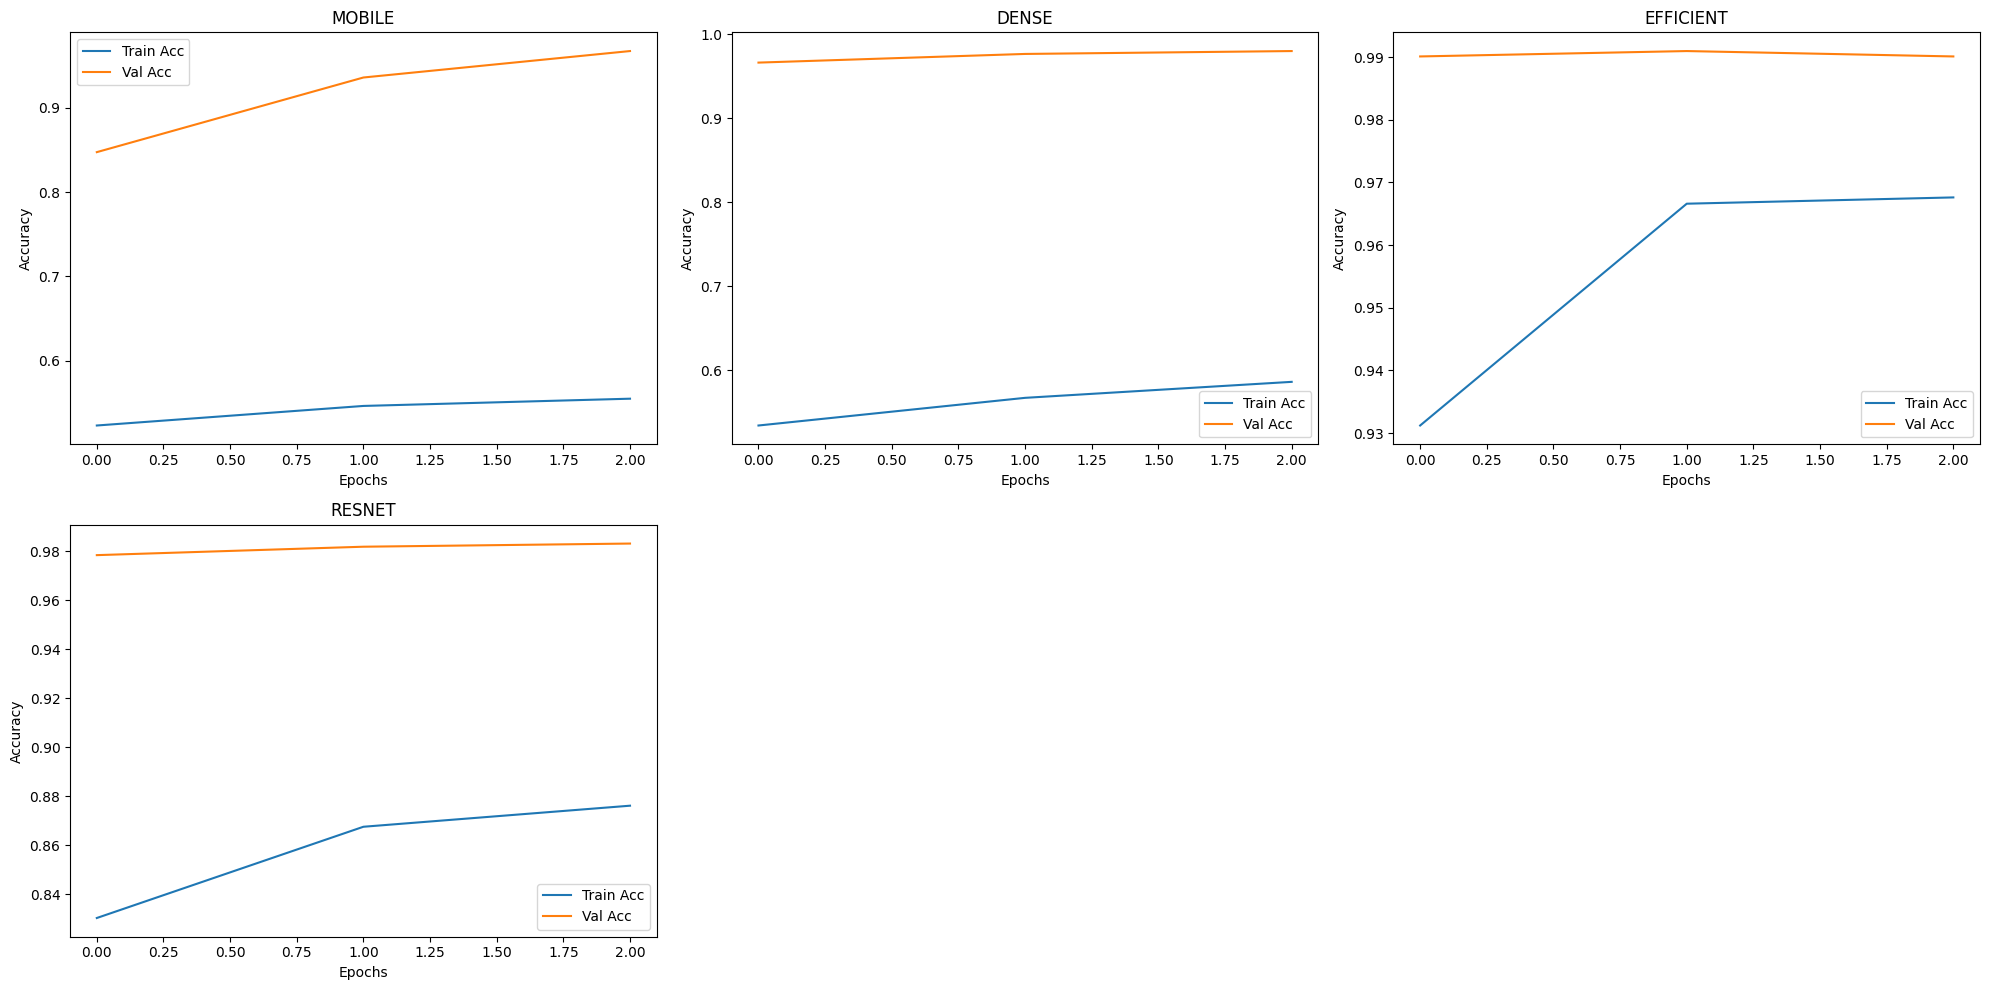

In [ ]:
plt.figure(figsize=(20, 10))
for i, name in enumerate(histories.keys()):
    history = histories[name]
    plt.subplot(2,3,i+1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(name.upper())
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np


def evaluate_model(name, preprocess_fn, test_dataset):

    base_model, _ = get_base_model(name,IMG_SIZE)


    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    #x = data_augmentation(inputs)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    outputs = layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)


    checkpoint_path = os.path.join(SAVE_DIR, f"{name}_best_weights.keras")
    model.load_weights(checkpoint_path)


    test_dataset = test_dataset.map(lambda x,y: (tf.image.resize(x, IMG_SIZE), y))
    test_dataset = test_dataset.map(lambda x,y: (preprocess_fn(x), y))
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred = np.concatenate([np.round(model.predict(x)) for x, y in test_dataset], axis=0)

    y_pred = np.argmax(y_pred, axis=1)

    report = classification_report(y_true, y_pred, target_names=['Cat','Dog'])
    print(f"\n==== Classification Report: {name.upper()} ====")
    print(report)


for name in ['resnet','mobile','dense','efficient']:
    _, preprocess_fn = get_base_model(name,IMG_SIZE)
    evaluate_model(name, preprocess_fn, test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 